In [1]:
# -*- coding: utf-8 -*-
"""
Induction Motor Field Oriented Control (FOC) Simulation

This notebook simulates the Field Oriented Control (FOC) of a
3-phase squirrel cage induction motor using Python.
FOC aims to control the induction motor like a separately excited DC motor
by decoupling the torque-producing and flux-producing components of the
stator current.

Libraries Used:
- NumPy: For numerical operations and arrays.
- SciPy: For numerical integration (solving differential equations).
- Matplotlib: For plotting the results.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

print("Libraries imported successfully.")

Libraries imported successfully.


### System Overview and "Circuit Diagram" Description

A typical hardware implementation of FOC for an Induction Motor involves:

1.  **Power Source:** Usually AC mains, rectified to DC.
2.  **Rectifier:** Converts AC input to a DC voltage.
3.  **DC Link Capacitor:** Smooths the rectified DC voltage and provides energy storage.
4.  **3-Phase Inverter:** Power electronic switches (like IGBTs or MOSFETs) that convert the DC voltage back into variable-frequency, variable-voltage 3-phase AC to drive the motor. This is controlled by PWM signals.
5.  **Induction Motor:** The machine being controlled.
6.  **Sensors:**
    * **Current Sensors:** Measure at least two of the phase currents (e.g., Ia, Ib). The third (Ic) can be calculated (Ia + Ib + Ic = 0).
    * **Position/Speed Sensor:** Typically an encoder or resolver mounted on the motor shaft to measure rotor position and speed. Sensorless FOC techniques exist but add complexity.
7.  **Control Unit (Microcontroller):** A digital signal processor (DSP) or microcontroller that performs the following:
    * Reads sensor values (currents, position/speed).
    * Executes the FOC algorithm (Clarke/Park transforms, PI controllers, Inverse Park transform, SVPWM).
    * Generates PWM signals for the inverter gates.

**Simulation Focus:**
This simulation focuses on the **control algorithm** and the **motor's dynamic model**. It abstracts the power electronics (assumes the inverter can perfectly produce the commanded voltages) and sensor noise/dynamics. We model the motor's electrical and mechanical behavior and how the FOC algorithm interacts with it.


In [2]:
# --- Motor Parameters (Example Values for a ~2.2kW Motor) ---
P = 4                # Number of poles
Rs = 0.435           # Stator resistance [Ohm]
Rr = 0.816           # Rotor resistance referred to stator [Ohm]
Ls = 0.070           # Stator inductance (Lls + Lm) [H] (using Ls notation for total)
Lr = 0.070           # Rotor inductance referred to stator (Llr + Lm) [H] (using Lr notation for total)
Lm = 0.068           # Mutual inductance [H]
# Calculate leakage inductances if needed, although often the full Ls/Lr are used directly
# Lls = Ls - Lm
# Llr = Lr - Lm
J = 0.089            # Moment of inertia [kg*m^2]
B = 0.005            # Viscous friction coefficient [N*m*s/rad] (Adjust as needed)

# --- Derived Parameters ---
sigma = 1 - Lm**2 / (Ls * Lr) # Leakage factor (often needed in some model formulations)
Tr = Lr / Rr                  # Rotor time constant

# --- Control Parameters ---
# PI Controller Gains (REQUIRES TUNING for optimal performance)
# Speed Controller
Kp_speed = 0.8 # Proportional gain
Ki_speed = 5.0 # Integral gain
speed_integral_limit = 5.0 # Anti-windup limit for speed controller integral term

# d-axis Current Controller (Flux)
Kp_id = 5.0    # Proportional gain
Ki_id = 50.0   # Integral gain
id_integral_limit = 200.0 # Anti-windup limit

# q-axis Current Controller (Torque)
Kp_iq = 5.0    # Proportional gain
Ki_iq = 50.0   # Integral gain
iq_integral_limit = 200.0 # Anti-windup limit

# --- Simulation Parameters ---
T_sim = 3.0          # Total simulation time [s]
dt = 0.0001          # Simulation time step [s] - Keep small for accuracy
T_load_change = 1.5  # Time when load torque is applied [s]
T_speed_change = 0.5 # Time when speed reference changes [s]

# --- FOC Setpoints ---
flux_ref = Lm * 5.0  # Target rotor flux linkage [Wb] (approx. based on desired Id)
# Calculate corresponding Id reference based on simplified steady state assumption:
id_ref = flux_ref / Lm # d-axis current reference [A]
iq_ref_max = 15.0    # Max torque current limit [A] (related to speed PI output limit)

# Initial Speed reference
speed_ref_initial_rad_s = 0.0 # Initial target speed [rad/s]
speed_ref_final_rad_s = 100.0 # Target speed after change [rad/s] (approx 955 RPM for P=4)

# Load Torque
T_load_initial = 0.0   # Initial Load torque [N*m]
T_load_final = 5.0     # Load torque applied later [N*m]

print(f"Motor Parameters Set. Target Flux linkage: {flux_ref:.3f} Wb (Id_ref = {id_ref:.2f} A)")
print(f"Control Gains Set (Kp_speed={Kp_speed}, Ki_speed={Ki_speed}, etc.)")
print(f"Simulation Time: {T_sim} s, Time Step: {dt} s")

Motor Parameters Set. Target Flux linkage: 0.340 Wb (Id_ref = 5.00 A)
Control Gains Set (Kp_speed=0.8, Ki_speed=5.0, etc.)
Simulation Time: 3.0 s, Time Step: 0.0001 s


In [3]:
# --- PI Controller Class ---
class PIController:
    def __init__(self, Kp, Ki, output_limit, integral_limit, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.output_limit = output_limit
        self.integral_limit = integral_limit
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0 # Not used in basic PI, but useful for PID

    def update(self, error):
        # Proportional term
        P_term = self.Kp * error

        # Integral term with anti-windup
        self.integral += error * self.dt
        # Clamp integral term
        if self.integral > self.integral_limit:
            self.integral = self.integral_limit
        elif self.integral < -self.integral_limit:
            self.integral = -self.integral_limit

        I_term = self.Ki * self.integral

        # Total output
        output = P_term + I_term

        # Clamp output
        if output > self.output_limit:
            output = self.output_limit
        elif output < -self.output_limit:
            output = -self.output_limit

        return output

    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0

# --- Coordinate Transformations (Not strictly needed for *this* simulation's core loop
# --- if we stay in dq, but good practice to have if interfacing with abc model) ---

# Clarke Transform (abc -> alpha, beta)
def clarke_transform(ia, ib, ic):
    alpha = (2.0/3.0) * (ia - 0.5*ib - 0.5*ic)
    beta = (2.0/3.0) * (math.sqrt(3)/2.0 * ib - math.sqrt(3)/2.0 * ic) # Power Invariant form
    # beta = (1.0/math.sqrt(3.0)) * (ib - ic) # Amplitude invariant alt
    return alpha, beta

# Park Transform (alpha, beta -> d, q)
def park_transform(alpha, beta, theta):
    d = alpha * math.cos(theta) + beta * math.sin(theta)
    q = -alpha * math.sin(theta) + beta * math.cos(theta)
    return d, q

# Inverse Park Transform (d, q -> alpha, beta)
def inverse_park_transform(d, q, theta):
    alpha = d * math.cos(theta) - q * math.sin(theta)
    beta = d * math.sin(theta) + q * math.cos(theta)
    return alpha, beta

# Inverse Clarke Transform (alpha, beta -> a, b, c) - Needed for SVPWM input
def inverse_clarke_transform(alpha, beta):
    va = alpha
    vb = -0.5 * alpha + (math.sqrt(3)/2.0) * beta
    vc = -0.5 * alpha - (math.sqrt(3)/2.0) * beta
    return va, vb, vc

print("Helper functions defined (PIController, Transformations).")

Helper functions defined (PIController, Transformations).


In [4]:
# --- Induction Motor State-Space Model in Synchronously Rotating (dq) Frame ---
# State vector: x = [id, iq, lambda_dr, lambda_qr, omega_m]
# Inputs: vd, vq, omega_sync (electrical synchronous speed), T_load
# Parameters: Rs, Rr, Ls, Lr, Lm, P, J, B

def induction_motor_dq_model(t, x, vd, vq, omega_sync, T_load, p):
    # Unpack state variables
    id, iq, lambda_dr, lambda_qr, omega_m = x
    # Unpack parameters
    Rs, Rr, Ls, Lr, Lm, P_motor, J_motor, B_motor = p

    # Calculate slip speed (omega_slip = omega_sync - omega_r)
    # omega_r is electrical rotor speed = omega_m * P/2
    omega_r_elec = omega_m * P_motor / 2.0
    omega_slip = omega_sync - omega_r_elec

    # Pre-calculate some terms for efficiency
    inv_Ls_sigma = 1.0 / (sigma * Ls) # sigma = 1 - Lm^2 / (Ls * Lr)
    Lm_Lr = Lm / Lr
    Rr_Lr = Rr / Lr
    Lm_sq_LsLr_sigma = Lm**2 / (sigma * Ls * Lr)


    # -- Electrical Subsystem --
    # Stator current derivatives (d(id)/dt, d(iq)/dt)
    # This form uses state variables id, iq, lambda_dr, lambda_qr directly
    # Note: Different formulations exist. This one aligns with common FOC literature.

    # Calculate rotor current components indirectly through flux linkages for the model
    # ir_d = (lambda_dr - Lm*id) / Lr
    # ir_q = (lambda_qr - Lm*iq) / Lr

    # Alternative, more direct state-space form often derived:
    # Define helper constants based on parameters
    k1 = -(Rs / (sigma * Ls) + (1 - sigma) * Rr / (sigma * Lr))
    k2 = omega_sync # comes from the derivative chain rule
    k3 = Lm * Rr / (sigma * Ls * Lr**2)
    k4 = Lm * omega_r_elec / (sigma * Ls * Lr) # P/2 factor included in omega_r_elec
    k5 = 1 / (sigma * Ls)

    k6 = -omega_sync # from derivative chain rule
    k7 = k1 # -(Rs / (sigma * Ls) + (1 - sigma) * Rr / (sigma * Lr))
    k8 = -k4 # -Lm * omega_r_elec / (sigma * Ls * Lr)
    k9 = k3 # Lm * Rr / (sigma * Ls * Lr**2)
    k10 = k5 # 1 / (sigma * Ls)


    # d(id)/dt = k1*id + k2*iq + k3*lambda_dr + k4*lambda_qr + k5*vd
    # d(iq)/dt = k6*id + k7*iq + k8*lambda_dr + k9*lambda_qr + k10*vq

    # Rotor flux linkage derivatives (d(lambda_dr)/dt, d(lambda_qr)/dt)
    # d(lambda_dr)/dt = (Lm * Rr / Lr) * id - (Rr / Lr) * lambda_dr + omega_slip * lambda_qr
    # d(lambda_qr)/dt = (Lm * Rr / Lr) * iq - omega_slip * lambda_dr - (Rr / Lr) * lambda_qr

    # Re-writing using intermediate terms for clarity:
    did_dt = (vd - Rs*id + omega_sync*Ls*sigma*iq + Lm_Lr*Rr*lambda_dr + Lm_Lr*omega_r_elec*lambda_qr) / (Ls*sigma)
    diq_dt = (vq - Rs*iq - omega_sync*Ls*sigma*id + Lm_Lr*omega_r_elec*lambda_dr - Lm_Lr*Rr*lambda_qr) / (Ls*sigma)

    dlambda_dr_dt = Lm * Rr / Lr * id - Rr / Lr * lambda_dr + omega_slip * lambda_qr
    dlambda_qr_dt = Lm * Rr / Lr * iq - Rr / Lr * lambda_qr - omega_slip * lambda_dr


    # -- Mechanical Subsystem --
    # Electromagnetic Torque (Te)
    # Te = (3/2) * (P/2) * (Lm/Lr) * (lambda_dr * iq - lambda_qr * id) # Full form
    # If FOC is working well, lambda_qr approx 0, lambda_dr approx flux_ref
    Te = (3.0/2.0) * (P_motor/2.0) * (Lm/Lr) * (lambda_dr * iq - lambda_qr * id)

    # Mechanical speed derivative (d(omega_m)/dt)
    domega_m_dt = (Te - T_load - B_motor * omega_m) / J_motor

    return [did_dt, diq_dt, dlambda_dr_dt, dlambda_qr_dt, domega_m_dt]

print("Induction motor model function defined.")

Induction motor model function defined.


In [5]:
# --- Initialize Controllers ---
pi_speed = PIController(Kp_speed, Ki_speed, iq_ref_max, speed_integral_limit, dt)
pi_id = PIController(Kp_id, Ki_id, 300, id_integral_limit, dt) # Voltage limit Vdq_max approx
pi_iq = PIController(Kp_iq, Ki_iq, 300, iq_integral_limit, dt) # Voltage limit Vdq_max approx


# --- Simulation Time Vector ---
t_eval = np.arange(0, T_sim, dt)
n_steps = len(t_eval)

# --- Data Storage ---
results = {
    't': t_eval,
    'id': np.zeros(n_steps),
    'iq': np.zeros(n_steps),
    'lambda_dr': np.zeros(n_steps),
    'lambda_qr': np.zeros(n_steps),
    'omega_m': np.zeros(n_steps), # Mechanical speed
    'omega_r_elec': np.zeros(n_steps), # Electrical speed
    'omega_sync': np.zeros(n_steps), # Synchronous speed (commanded)
    'Te': np.zeros(n_steps),
    'T_load': np.zeros(n_steps),
    'speed_ref': np.zeros(n_steps),
    'id_ref': np.zeros(n_steps),
    'iq_ref': np.zeros(n_steps),
    'vd': np.zeros(n_steps),
    'vq': np.zeros(n_steps),
    'rotor_angle': np.zeros(n_steps) # Electrical angle theta_e
}

# --- Initial Conditions ---
x0 = [0.0, 0.0, 0.0, 0.0, 0.0] # Initial state: [id, iq, lambda_dr, lambda_qr, omega_m]
current_state = np.array(x0)
current_T_load = T_load_initial
current_speed_ref = speed_ref_initial_rad_s
theta_e = 0.0 # Initial electrical angle

motor_params = (Rs, Rr, Ls, Lr, Lm, P, J, B)


# --- Simulation Loop (Manual Step-by-Step Integration) ---
print("Starting simulation...")
for i in range(n_steps):
    # --- Get Current State ---
    id_meas = current_state[0]
    iq_meas = current_state[1]
    lambda_dr_est = current_state[2] # In simulation, we know the state
    lambda_qr_est = current_state[3] # In reality, these are estimated
    omega_m_mech = current_state[4]
    omega_r_elec = omega_m_mech * P / 2.0

    # --- Update Setpoints based on time ---
    if t_eval[i] >= T_speed_change:
        current_speed_ref = speed_ref_final_rad_s
    if t_eval[i] >= T_load_change:
        current_T_load = T_load_final

    # --- FOC Control Algorithm Execution ---
    # 1. Speed Control Loop
    speed_error = current_speed_ref - omega_m_mech
    iq_ref_cmd = pi_speed.update(speed_error)

    # 2. Current Control Loops (d-axis and q-axis)
    id_error = id_ref - id_meas
    iq_error = iq_ref_cmd - iq_meas

    # Calculate synchronous speed estimate for decoupling terms
    # omega_sync_est = omega_r_elec + (Rr / Lr) * (Lm * iq_meas / lambda_dr_est if abs(lambda_dr_est) > 1e-3 else 0) # Simplified slip calculation for decoupling
    # A simpler approach often used in simulation is to use the calculated omega_sync from the controllers
    # Or, even more simply in basic FOC, use omega_r_elec directly in cross-coupling if model assumes dq frame aligned with rotor flux.
    # Let's try feeding the calculated omega_sync into the model next step.

    # Calculate decoupling terms (simplified - neglecting some dynamics for clarity here)
    # More accurate decoupling: vd_decouple = -omega_sync_est * sigma * Ls * iq_meas
    #                          vq_decouple =  omega_sync_est * (sigma * Ls * id_meas + (Lm/Lr)*lambda_dr_est) # Includes field weakening term implicitly if id_ref changes
    vd_decouple = -omega_r_elec * Ls * iq_meas # Simplified decoupling using electrical speed and Ls
    vq_decouple =  omega_r_elec * (Ls * id_meas + Lm * (lambda_dr_est / Lr if Lr > 0 else 0)) # Simpler form, uses Ls, Lm/Lr*lambda_dr approx flux

    # PI Controller outputs for voltage components
    vd_ctrl = pi_id.update(id_error)
    vq_ctrl = pi_iq.update(iq_error)

    # Total commanded voltages
    vd_cmd = vd_ctrl + vd_decouple
    vq_cmd = vq_ctrl + vq_decouple


    # --- Calculate omega_sync for the model input ---
    # Based on rotor flux position (requires flux estimation in real system)
    # Estimate rotor flux angle using state variables: theta_flux = atan2(lambda_qr, lambda_dr)
    # Estimate slip speed: omega_slip_est = (Rr * Lm * iq_meas) / (Lr * lambda_dr_est) if abs(lambda_dr_est) > 1e-3 else 0 # Simplified steady-state version
    # omega_sync_cmd = omega_r_elec + omega_slip_est

    # Alternative for simulation: Use estimated slip based on iq command and flux reference
    if abs(flux_ref) > 1e-3: # Avoid division by zero
         omega_slip_cmd = (Rr * Lm * iq_ref_cmd) / (Lr * flux_ref)
    else:
         omega_slip_cmd = 0
    omega_sync_cmd = omega_r_elec + omega_slip_cmd


    # --- Store Results ---
    results['id'][i] = id_meas
    results['iq'][i] = iq_meas
    results['lambda_dr'][i] = lambda_dr_est
    results['lambda_qr'][i] = lambda_qr_est
    results['omega_m'][i] = omega_m_mech
    results['omega_r_elec'][i] = omega_r_elec
    results['Te'][i] = (3.0/2.0) * (P/2.0) * (Lm/Lr) * (lambda_dr_est * iq_meas - lambda_qr_est * id_meas)
    results['T_load'][i] = current_T_load
    results['speed_ref'][i] = current_speed_ref
    results['id_ref'][i] = id_ref
    results['iq_ref'][i] = iq_ref_cmd
    results['vd'][i] = vd_cmd
    results['vq'][i] = vq_cmd
    results['omega_sync'][i] = omega_sync_cmd
    results['rotor_angle'][i] = theta_e


    # --- Integrate Motor Dynamics for One Step ---
    # Use Euler method for simplicity in this loop structure
    # Or use solve_ivp for a single step (less efficient but possible)

    # Euler Step:
    derivs = induction_motor_dq_model(t_eval[i], current_state, vd_cmd, vq_cmd, omega_sync_cmd, current_T_load, motor_params)
    current_state += np.array(derivs) * dt

    # --- Update Electrical Angle (Integral of omega_sync) ---
    # This angle is crucial for transformations in a real system. In this dq model simulation,
    # it's primarily used by the model equations (implicitly via omega_sync input) and for potential plotting/analysis.
    theta_e += omega_sync_cmd * dt
    theta_e = theta_e % (2 * np.pi) # Keep angle within 0 to 2*pi


    # --- Print Progress ---
    if i % (n_steps // 10) == 0:
      print(f"Simulation progress: {i / n_steps * 100:.0f}%")


print("Simulation finished.")

Starting simulation...
Simulation progress: 0%
Simulation progress: 10%
Simulation progress: 20%
Simulation progress: 30%
Simulation progress: 40%
Simulation progress: 50%
Simulation progress: 60%
Simulation progress: 70%
Simulation progress: 80%


<ipython-input-5-7c5d6da35626>:76: RuntimeWarning: overflow encountered in scalar multiply
  vd_decouple = -omega_r_elec * Ls * iq_meas # Simplified decoupling using electrical speed and Ls
<ipython-input-5-7c5d6da35626>:77: RuntimeWarning: overflow encountered in scalar multiply
  vq_decouple =  omega_r_elec * (Ls * id_meas + Lm * (lambda_dr_est / Lr if Lr > 0 else 0)) # Simpler form, uses Ls, Lm/Lr*lambda_dr approx flux
<ipython-input-4-8a2792f2029b>:56: RuntimeWarning: overflow encountered in scalar multiply
  did_dt = (vd - Rs*id + omega_sync*Ls*sigma*iq + Lm_Lr*Rr*lambda_dr + Lm_Lr*omega_r_elec*lambda_qr) / (Ls*sigma)
<ipython-input-4-8a2792f2029b>:56: RuntimeWarning: invalid value encountered in scalar add
  did_dt = (vd - Rs*id + omega_sync*Ls*sigma*iq + Lm_Lr*Rr*lambda_dr + Lm_Lr*omega_r_elec*lambda_qr) / (Ls*sigma)
<ipython-input-4-8a2792f2029b>:57: RuntimeWarning: overflow encountered in scalar multiply
  diq_dt = (vq - Rs*iq - omega_sync*Ls*sigma*id + Lm_Lr*omega_r_elec*lamb

Simulation progress: 90%
Simulation finished.


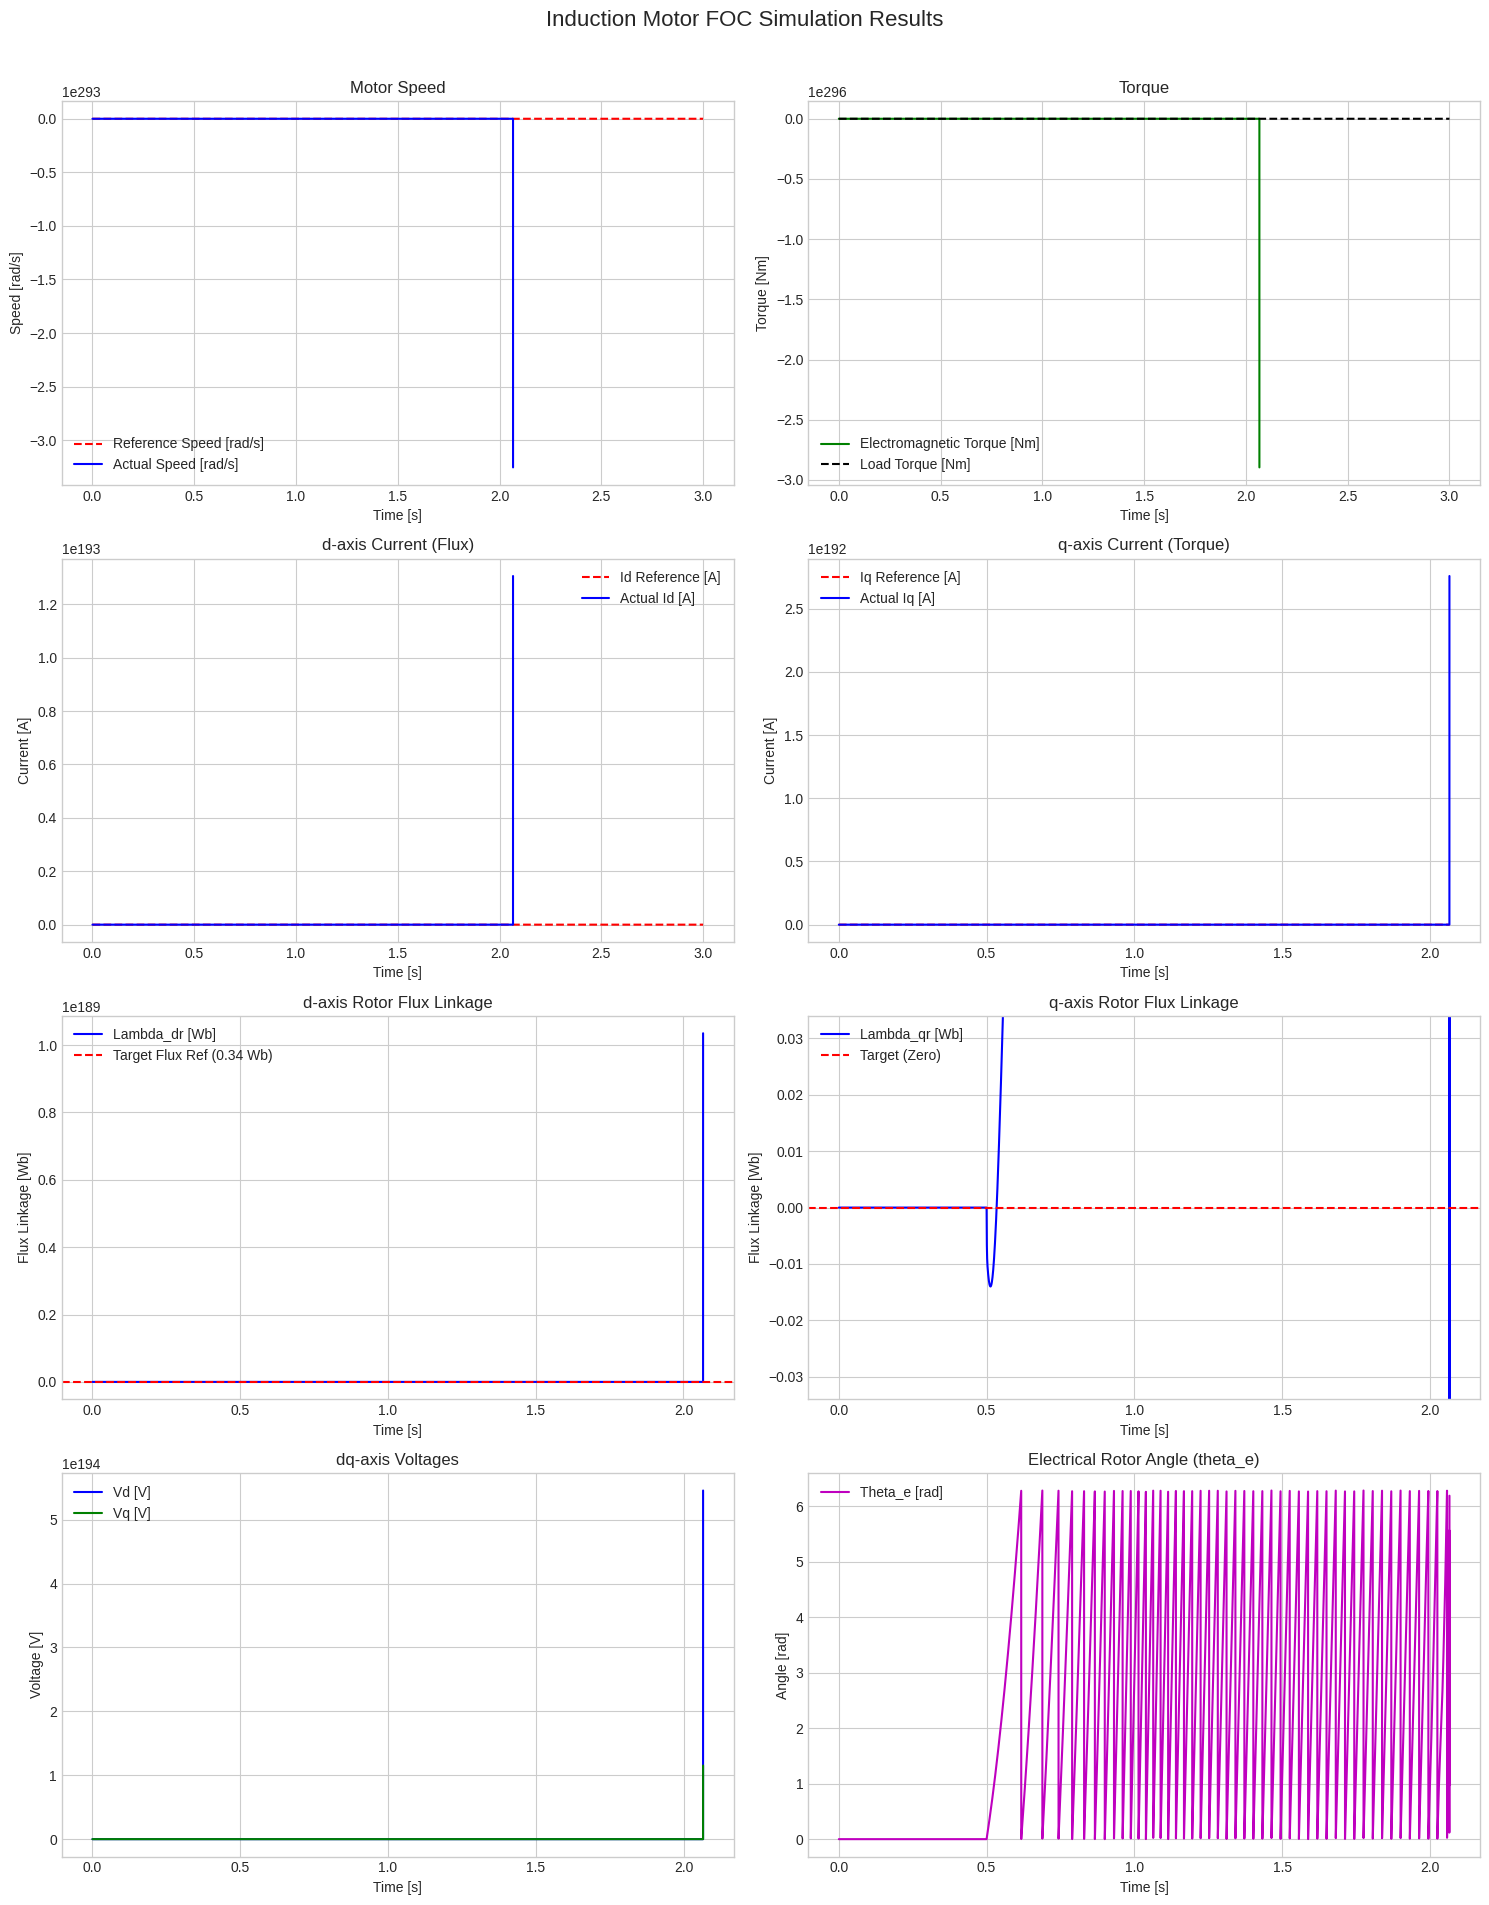

In [6]:
# --- Plot Results ---
plt.style.use('seaborn-v0_8-whitegrid') # Nicer plot style
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Induction Motor FOC Simulation Results', fontsize=16)

t = results['t']

# Speed Plot
axs[0, 0].plot(t, results['speed_ref'], 'r--', label='Reference Speed [rad/s]')
axs[0, 0].plot(t, results['omega_m'], 'b-', label='Actual Speed [rad/s]')
axs[0, 0].set_title('Motor Speed')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('Speed [rad/s]')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Torque Plot
axs[0, 1].plot(t, results['Te'], 'g-', label='Electromagnetic Torque [Nm]')
axs[0, 1].plot(t, results['T_load'], 'k--', label='Load Torque [Nm]')
axs[0, 1].set_title('Torque')
axs[0, 1].set_xlabel('Time [s]')
axs[0, 1].set_ylabel('Torque [Nm]')
axs[0, 1].legend()
axs[0, 1].grid(True)

# d-axis Current Plot
axs[1, 0].plot(t, results['id_ref'], 'r--', label='Id Reference [A]')
axs[1, 0].plot(t, results['id'], 'b-', label='Actual Id [A]')
axs[1, 0].set_title('d-axis Current (Flux)')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Current [A]')
axs[1, 0].legend()
axs[1, 0].grid(True)

# q-axis Current Plot
axs[1, 1].plot(t, results['iq_ref'], 'r--', label='Iq Reference [A]')
axs[1, 1].plot(t, results['iq'], 'b-', label='Actual Iq [A]')
axs[1, 1].set_title('q-axis Current (Torque)')
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Current [A]')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Rotor Flux Linkage (d-axis) Plot
axs[2, 0].plot(t, results['lambda_dr'], 'b-', label='Lambda_dr [Wb]')
# Optionally plot the reference flux level
axs[2, 0].axhline(flux_ref, color='r', linestyle='--', label=f'Target Flux Ref ({flux_ref:.2f} Wb)')
axs[2, 0].set_title('d-axis Rotor Flux Linkage')
axs[2, 0].set_xlabel('Time [s]')
axs[2, 0].set_ylabel('Flux Linkage [Wb]')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Rotor Flux Linkage (q-axis) Plot
axs[2, 1].plot(t, results['lambda_qr'], 'b-', label='Lambda_qr [Wb]')
axs[2, 1].axhline(0, color='r', linestyle='--', label='Target (Zero)')
axs[2, 1].set_title('q-axis Rotor Flux Linkage')
axs[2, 1].set_xlabel('Time [s]')
axs[2, 1].set_ylabel('Flux Linkage [Wb]')
axs[2, 1].legend()
axs[2, 1].grid(True)
axs[2, 1].set_ylim([-0.1 * flux_ref, 0.1 * flux_ref]) # Zoom in near zero

# dq Voltages Plot
axs[3, 0].plot(t, results['vd'], 'b-', label='Vd [V]')
axs[3, 0].plot(t, results['vq'], 'g-', label='Vq [V]')
axs[3, 0].set_title('dq-axis Voltages')
axs[3, 0].set_xlabel('Time [s]')
axs[3, 0].set_ylabel('Voltage [V]')
axs[3, 0].legend()
axs[3, 0].grid(True)

# Rotor Angle (Electrical) Plot - Shows rotation
axs[3, 1].plot(t, results['rotor_angle'], 'm-', label='Theta_e [rad]')
axs[3, 1].set_title('Electrical Rotor Angle (theta_e)')
axs[3, 1].set_xlabel('Time [s]')
axs[3, 1].set_ylabel('Angle [rad]')
axs[3, 1].legend()
axs[3, 1].grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
plt.show()